In [4]:
# Importing Required Modules
import cv2
import numpy as np
from rembg import remove
from PIL import Image
from skimage.morphology import skeletonize
from skimage.io import imsave
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import os
import glob

### Remove background + binarize + skeletonize

In [51]:
# Root directory ControlNet-Trees
ROOT_DIR = os.path.dirname(os.path.abspath(''))
ROOT_DIR_GIS = os.path.join(ROOT_DIR, 'Google-Image-Scraper')
output_folder = os.path.join(ROOT_DIR_GIS,'photos','tree_skeleton')

def get_files_folder(path):
    image_list = []
    for filename in glob.glob(os.path.join(path,'*')):
        im=filename #Image.open(filename)
        image_list.append(im)
    return image_list

def binarize_transparent(img_pil, threshold=0):
    #https://stackoverflow.com/questions/61918194/how-to-make-a-binary-mask-out-of-an-image-with-a-transparent-background
    #https://learnopencv.com/opencv-threshold-python-cpp/
    
    # load image with alpha channel
    #img = cv2.imread('object.png', cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGBA2BGRA)

    # extract alpha channel
    alpha = img[:, :, 3]

    # threshold alpha channel
    alpha = cv2.threshold(alpha, threshold, 255, cv2.THRESH_BINARY)[1]

    return alpha

def opening_closing(img_cv2):
    kernel_open = np.ones((21,21),np.uint8)
    kernel_close = np.ones((15,15),np.uint8)

    opening = cv2.morphologyEx(img_cv2, cv2.MORPH_OPEN, kernel_open)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)

    return opening, closing
    
  
def run_training_data_pipeline(input_path):

    img_nr = input_path.split(".")[-2][-1]
    
    # Store path of the output image in the variable output_path
    output_path_bg = os.path.join(output_folder, f'tree{img_nr}_rembg.png')
    output_path_bin = os.path.join(output_folder, f'tree{img_nr}_binary.png')
    output_path_closing = os.path.join(output_folder, f'tree{img_nr}_closing.png')
    output_path_skel = os.path.join(output_folder, f'tree{img_nr}_skel.png')
    
    # Open the image
    input = Image.open(input_path)
    
    # Removing the background
    output = remove(input)
    output.save(output_path_bg)

    # Binarize
    output = binarize_transparent(output)
    cv2.imwrite(output_path_bin, output)

    # Opening and closing
    opening, closing = opening_closing(output)
    cv2.imwrite(output_path_closing, closing)

    # Skeletonize
    skeleton = skeletonize(closing)
    imsave(output_path_skel, img_as_ubyte(skeleton), check_contrast=False)

    return f'Image {img_nr} processed and results saved'


In [42]:
# Only one image
run_training_data_pipeline(os.path.join(ROOT_DIR_GIS,'photos','tree','tree8.webp'))

In [46]:
# All images in input folder
in_folder = os.path.join(ROOT_DIR_GIS, 'photos','tree')
img_list = get_files_folder(in_folder)
for img in img_list:
    try:
        print(run_training_data_pipeline(img))
    except Exception as error:
        print("An error occurred:", error)

Image 0 processed and results saved
Image 1 processed and results saved
Image 2 processed and results saved
Image 3 processed and results saved
Image 5 processed and results saved
Image 6 processed and results saved
Image 7 processed and results saved
Image 8 processed and results saved
Image 9 processed and results saved


### Opening and Closing
Improve binary image by applying [morphological transformations](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html):
1. opening: remove white noise
2. closing: fill holes 

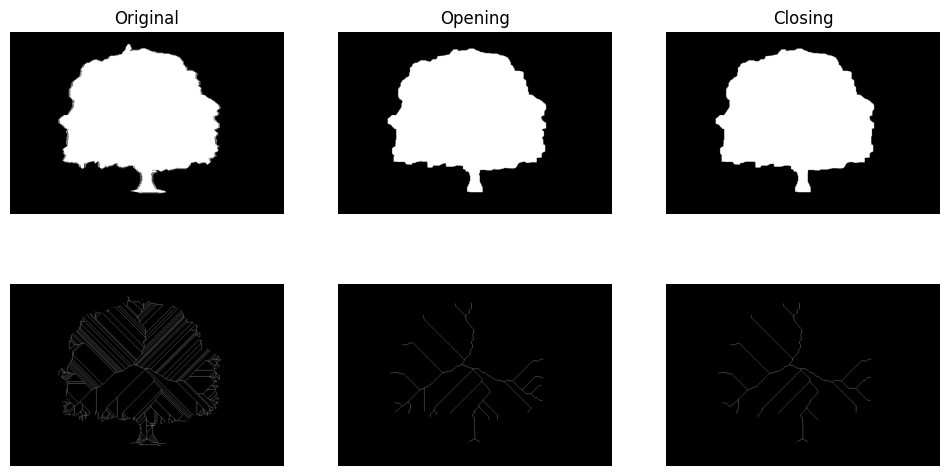

In [33]:
img_nr = 2
output_path_bin = os.path.join(output_folder, f'tree{img_nr}_binary.png')
img = cv2.imread(output_path_bin, cv2.IMREAD_GRAYSCALE)

opening, closing = opening_closing(img)

# save image closing
cv2.imwrite(os.path.join(output_folder, f'tree{img_nr}_closing.png'), closing)

# Display the results and their skeletons
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax = np.ravel(ax)
[axi.set_axis_off() for axi in ax]
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(opening, cmap='gray')
ax[1].set_title('Opening')
ax[2].imshow(closing, cmap='gray')
ax[2].set_title('Closing')
ax[3].imshow(skeletonize(img), cmap='gray')
ax[4].imshow(skeletonize(opening), cmap='gray')
ax[5].imshow(skeletonize(closing), cmap='gray')
plt.show()

### Depth image

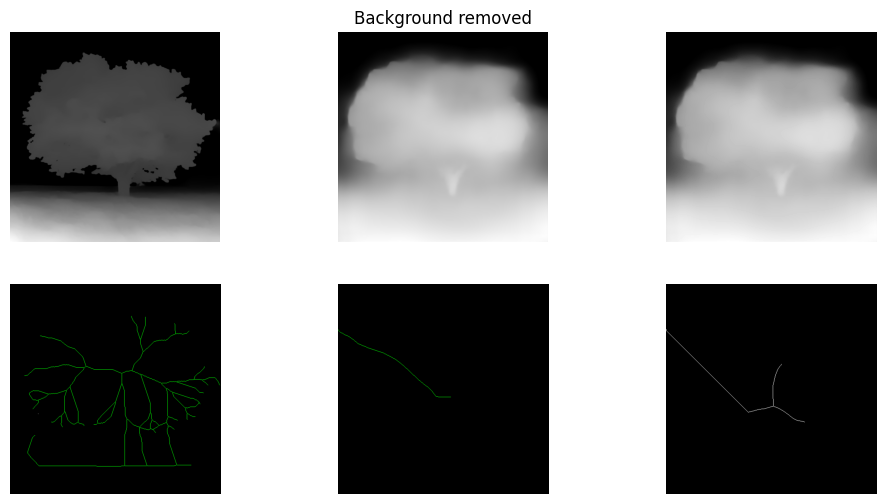

In [55]:
"""
import sys
sys.path.append('../../stable-diffusion-webui/extensions/sd-webui-controlnet')
from annotator.midas import MidasDetector
"""
from controlnet_aux import MidasDetector

img_nr = 8
img_path = os.path.join(output_folder, f'tree{img_nr}.webp') #.jpeg') 
#img_rembg_path = os.path.join(output_folder, f'tree{img_nr}_rembg.png')
img = Image.open(img_path).resize((512, 512))

midas = MidasDetector.from_pretrained("lllyasviel/Annotators")

# Image to depth map
depth_img = midas(img)
depth_img.save(os.path.join(output_folder, f'tree{img_nr}_depth.png'))
skeleton = skeletonize(np.asarray(depth_img))

# Image(removed background) to depth map
#img = remove(img)
img_rembg_path = os.path.join(output_folder, f'tree{img_nr}_rembg.png')
img = Image.open(img_rembg_path).resize((512, 512))
depth_bgimg = midas(img)
depth_bgimg.save(os.path.join(output_folder, f'tree{img_nr}_bgdepth.png'))
skeleton_bg = skeletonize(np.asarray(depth_bgimg))

# Image (rembg & binary) to depth map
depth_cv2 = cv2.cvtColor(np.asarray(depth_bgimg), cv2.COLOR_RGB2GRAY)
th, bin_img = cv2.threshold(depth_cv2, 0, 255, cv2.THRESH_BINARY)
skeleton_bin = skeletonize(np.asarray(bin_img))

# Display all images
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
[axi.set_axis_off() for axi in ax.ravel()]
ax[0,0].imshow(depth_img, cmap='gray')
ax[1,0].imshow(skeleton, cmap='gray')
ax[0,1].set_title('Background removed')
ax[0,1].imshow(depth_bgimg, cmap='gray')
ax[1,1].imshow(skeleton_bg, cmap='gray')
ax[0,2].imshow(bin_img, cmap='gray')
ax[1,2].imshow(skeleton_bin, cmap='gray')

plt.show()

### Compare diff skel algos
https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html

In [16]:
from skimage.morphology import medial_axis, skeletonize
import matplotlib.pyplot as plt
from skimage.io import imread


def compare_skel_algos(img_nr):
    output_path_bin = os.path.join(ROOT_DIR_GIS, 'photos','tree_skeleton',f'tree{img_nr}_binary.png')
    img = imread(output_path_bin)

    # Compute the medial axis (skeleton) and the distance transform
    skel, distance = medial_axis(img, return_distance=True)

    # Compare with other skeletonization algorithms
    skeleton = skeletonize(img)
    skeleton_lee = skeletonize(img, method='lee')

    # Distance to the background for pixels of the skeleton
    dist_on_skel = distance * skel

    fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('original')
    ax[0].axis('off')

    #ax[1].imshow(dist_on_skel, cmap='magma')
    #ax[1].contour(img, [0.5], colors='w')
    ax[1].imshow(skel, cmap=plt.cm.gray)
    ax[1].set_title('medial_axis')
    ax[1].axis('off')

    ax[2].imshow(skeleton, cmap=plt.cm.gray)
    ax[2].set_title('skeletonize')
    ax[2].axis('off')

    ax[3].imshow(skeleton_lee, cmap=plt.cm.gray)
    ax[3].set_title("skeletonize (Lee 94)")
    ax[3].axis('off')

    fig.tight_layout()
    plt.show()

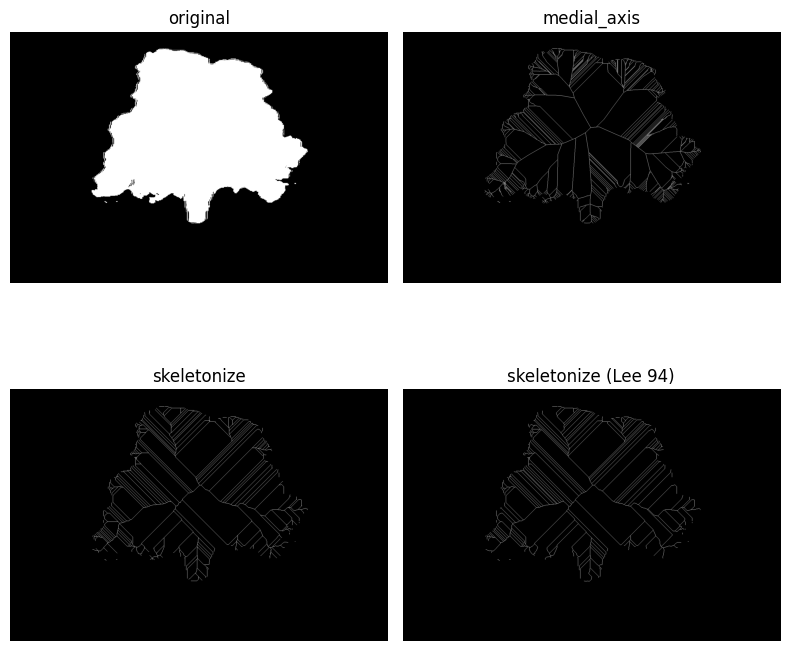

In [20]:
compare_skel_algos(5)

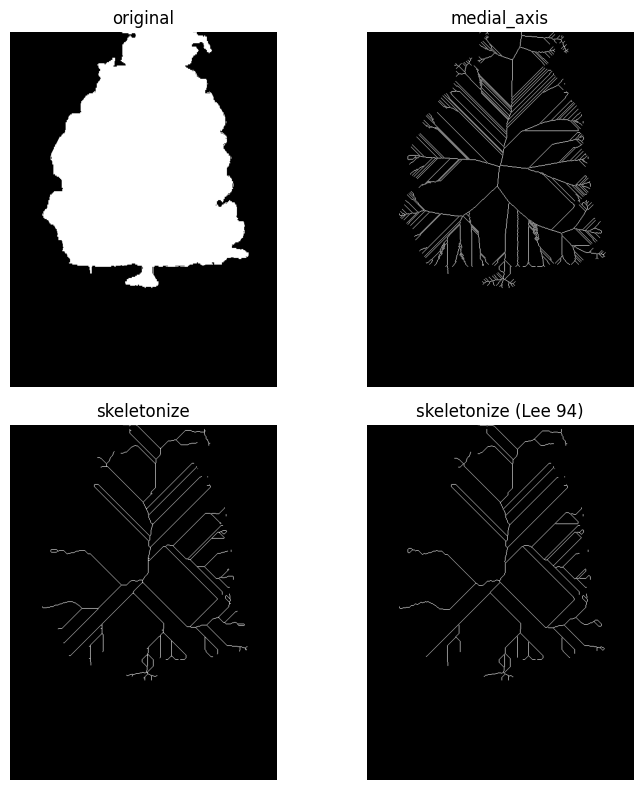

In [28]:
compare_skel_algos(0)